In [1]:
from argparse import ArgumentParser

import os
import sys
import time

import matplotlib.pyplot as plt

import geopandas as gpd
import pandas as pd

from pandarallel import pandarallel

sys.path.insert(1, '../scripts/')
from reaches import readNHD
from utils import specialBuffer

In [3]:
slurm = 197
# slurm = int(os.environ['SLURM_ARRAY_TASK_ID'])
cpus = int(os.environ.get('SLURM_CPUS_PER_TASK'))
cpus_per_task = cpus if cpus < 65 else 1

In [5]:
# # FOR NOW, SET
width_set = 'max'

# ### PARSE ARGUMENTS
# parser = ArgumentParser(description='Please specify whether you would\
#                         like to use the min, mean, or max predicted\
#                         bankfull width for this analysis.')
# parser.add_argument('width_set', type=str, help='min, mean, or max')
# args=parser.parse_args()
# width_set = args.width_set

In [6]:
# Control flow
if width_set == 'mean':
    width = 'WidthM'
elif width_set == 'min':
    width = 'WidthM_Min'
elif width_set == 'max':
    width = 'WidthM_Max'
else:
    print('Invalid width option specified, exiting.')
    # sys.exit()

In [7]:
## Prepare data
# Read segmented NHD
segments, huc4, huc2 = readNHD(index=slurm, segmented=True)

type: segmented
NHDPLUS_H_0512_HU4_GDB
/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_segmented/HUC2_05/NHDPLUS_H_0512_HU4_GDB_prepped_segmented.parquet
segments read-in


In [8]:
pandarallel.initialize(nb_workers=cpus_per_task)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [9]:
# Buffer segments
## PARALLELIZE
start = time.time()
segments['buffer'] = segments.parallel_apply(user_defined_function=specialBuffer,
                                                         args=(width,
                                                               'flat', True, False),
                                                         axis=1)
end = time.time()
print(end - start)

141.5606770515442


In [8]:
# fig, ax = plt.subplots()
# segments.iloc[0:10].segments.plot(ax=ax, cmap='hsv')
# segments.iloc[0:10].buffers.plot(ax=ax, cmap='summer', alpha=0.7)

In [10]:
# Drop original reach geometry column, set segments as active geometry
segments = segments.drop(columns='segments').set_geometry('buffer').set_crs(crs=segments.crs)

In [11]:
save_path = '../../narrow_rivers_PIXC_data/NHD_prepped_segmented_buffered/'

In [12]:
# Write out
# Set write filepath
save_path = '../../narrow_rivers_PIXC_data/NHD_prepped_segmented_buffered/'
save_path = os.path.join(save_path, huc2)
save_file = huc4 + '_buffered_' + width_set + '.parquet'

#Write out gdf as parquet file
if not os.path.isdir(save_path):
    os.makedirs(save_path)
segments.to_parquet(os.path.join(save_path, save_file))

In [13]:
print('Script completed.')

Script completed.


In [12]:
# del segments

In [21]:
start = time.time()
# test = gpd.read_parquet('/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_segmented_buffered/HUC2_01/NHDPLUS_H_0102_HU4_GDB_prepped_segmented_buffered_min.parquet')
test = gpd.read_parquet('/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_buffered_extra/HUC2_01/NHDPLUS_H_0102_HU4_GDB_prepped_buffered_extra_min.parquet')
end = time.time()

end - start

0.708996057510376

In [24]:
test = gpd.read_parquet('/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_segmented/HUC2_01/NHDPLUS_H_0102_HU4_GDB_prepped_segmented.parquet')

In [25]:
test

,NHDPlusID,GNIS_Name,LengthKM,WidthM,WidthM_Min,WidthM_Max,Bin,Bin_Min,Bin_Max,StreamOrde,Slope,segments
0,5.000500e+12,None,0.011,3.106102,2.356219,4.094640,"(0, 10]","(0, 10]","(0, 10]",1,0.000010,"LINESTRING (-7788776.503 5801117.101, -7788775..."
0,5.000500e+12,None,0.011,3.106102,2.356219,4.094640,"(0, 10]","(0, 10]","(0, 10]",1,0.000010,"LINESTRING (-7788775.187 5801116.262, -7788773..."
0,5.000500e+12,None,0.011,3.106102,2.356219,4.094640,"(0, 10]","(0, 10]","(0, 10]",1,0.000010,"LINESTRING (-7788773.871 5801115.422, -7788772..."
0,5.000500e+12,None,0.011,3.106102,2.356219,4.094640,"(0, 10]","(0, 10]","(0, 10]",1,0.000010,"LINESTRING (-7788772.555 5801114.583, -7788771..."
0,5.000500e+12,None,0.011,3.106102,2.356219,4.094640,"(0, 10]","(0, 10]","(0, 10]",1,0.000010,"LINESTRING (-7788771.24 5801113.743, -7788769...."
...,...,...,...,...,...,...,...,...,...,...,...,...
23568,5.000500e+12,Salmon Stream,0.131,22.253802,16.881235,29.336224,"(20, 30]","(10, 20]","(20, 30]",3,0.000076,"LINESTRING (-7623087.236 5734463.607, -7623088..."
23568,5.000500e+12,Salmon Stream,0.131,22.253802,16.881235,29.336224,"(20, 30]","(10, 20]","(20, 30]",3,0.000076,"LINESTRING (-7623088.978 5734444.962, -7623090..."
23568,5.000500e+12,Salmon Stream,0.131,22.253802,16.881235,29.336224,"(20, 30]","(10, 20]","(20, 30]",3,0.000076,"LINESTRING (-7623090.72 5734426.317, -7623092...."
23568,5.000500e+12,Salmon Stream,0.131,22.253802,16.881235,29.336224,"(20, 30]","(10, 20]","(20, 30]",3,0.000076,"LINESTRING (-7623092.463 5734407.672, -7623094..."


<Axes: >

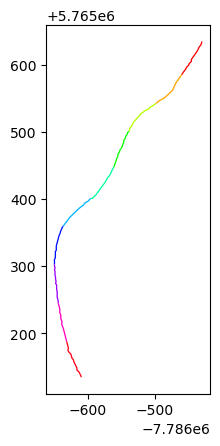

In [16]:
test[40:50].plot(cmap='hsv')
# plt.xlim(-7680000, -7640000)
# plt.ylim(5520000, 5560000)